# Global preparations

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import logging
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from tqdm.notebook import tqdm

sys.path.insert(0, os.path.expanduser('~/andn'))
device = 'cuda:0'
summation_dtype = torch.float32
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True
logger = logging.getLogger('stdout_logger')
logger.setLevel(logging.INFO)
if not logger.hasHandlers():
    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setFormatter(logging.Formatter(fmt='%(asctime)s|%(levelname)s|%(message)s'))
    logger.addHandler(stdout_handler)

# MNIST preparation

Let's read the MNIST dataset and represent it in sparse form

In [2]:
from andn.util.sparsify import NearestPointSparsifier
mnist_dataset_dir = 'mnist'

# intensity_levels_dim_h = 4
# intensity_levels_dim_w = 4
# input_modules_distribution = torch.tensor([[1, 2, 2, 3], [3, 3, 4, 4], [4, 4, 4, 4], [0, 0, 0, 0]], dtype=torch.int32)
# treat_zero_as_zero = True
# sparsify_transform = NearestPointSparsifier(
#     n_channels=-1,z
#     per_pixel_modules_distribution=input_modules_distribution,
#     sparsifying_rules=[
#         (0, 1, [1.0], treat_zero_as_zero),
#         (0, 2, [1.0 / 2, 1.0], treat_zero_as_zero),
#         (0, 3, [1.0 / 3, 2.0 / 3, 1.0], treat_zero_as_zero),
#         (0, 4, [1.0 / 6, 2.0 / 6, 3.0 / 6, 4.0 / 6, 5.0 / 6, 1.0], treat_zero_as_zero)
#     ]
# )

intensity_levels_dim_h = 4
intensity_levels_dim_w = 4
input_modules_distribution = torch.tensor([[1, 1, 2, 2], [2, 3, 3, 3], [3, 4, 4, 4], [4, 4, 4, 4]], dtype=torch.int32)
treat_zero_as_zero = False
sparsify_transform = NearestPointSparsifier(
    n_channels=-1,
    per_pixel_modules_distribution=input_modules_distribution,
    sparsifying_rules=[
        (0, 1, [1.0], treat_zero_as_zero),
        (0, 2, [1.0 / 2, 1.0], treat_zero_as_zero),
        (0, 3, [1.0 / 3, 2.0 / 3, 1.0], treat_zero_as_zero),
        (0, 4, [1.0 / 6, 2.0 / 6, 3.0 / 6, 4.0 / 6, 5.0 / 6, 1.0], treat_zero_as_zero)
    ]
)

input_modules_shape = (intensity_levels_dim_h, intensity_levels_dim_w)

In [3]:
from torchvision.datasets.utils import download_and_extract_archive, extract_archive

In [4]:
download_and_extract_archive(
    'https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip', 
    download_root='./EMNIST/EMNIST/raw', 
    md5="58c8d27c78d21e728a6bc7b3cc06412e"
)

Using downloaded and verified file: ./EMNIST/EMNIST/raw/gzip.zip
Extracting ./EMNIST/EMNIST/raw/gzip.zip to ./EMNIST/EMNIST/raw


In [5]:
import shutil
gzip_folder = os.path.join('./EMNIST/EMNIST/raw', "gzip")
for gzip_file in os.listdir(gzip_folder):
    if gzip_file.endswith(".gz"):
        extract_archive(os.path.join(gzip_folder, gzip_file), './EMNIST/EMNIST/raw')
shutil.rmtree(gzip_folder)

In [6]:
import torchvision
import torchvision.transforms as transforms
emnist_trainset = torchvision.datasets.EMNIST(
   root="./EMNIST",
   split="letters",#letters #digits 
   train=True,
   download=False,
   transform=transforms.ToTensor() 
)
emnist_trainset = TensorDataset(emnist_trainset.data.to(device=device).to(dtype=torch.float32) / 255, emnist_trainset.targets.to(device=device))
len(emnist_trainset)

124800

In [7]:
# class SparsifyTransformWrapper(object):
#     def __init__(self, sparsify_transform):
#         self._internal_transform = sparsify_transform
        
#     def __call__(self, data):
#         return (self._internal_transform(data) + 1.0) * 0.5
    
#     def reverse(self, sparse_data):
#         return self._internal_transform.reverse((sparse_data - 0.5) * 2)
    
#     def set_use_cache(self, val):
#         self._internal_transform.set_use_cache(val)
        
# sparsify_transform = SparsifyTransformWrapper(sparsify_transform)

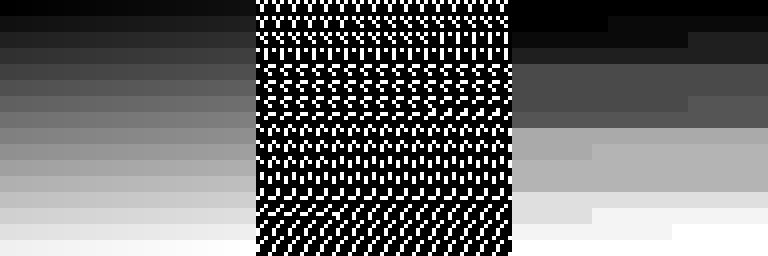

In [8]:
from andn.util.sparsify import prepare_sparsify_transform_and_input_modules_distribution

gradient_example = torch.arange(256).reshape(16, 16) / 255
sparsified_gradient_example = sparsify_transform(gradient_example.unsqueeze(0))
reverse_gradient = sparsify_transform.reverse(sparsified_gradient_example)
gradient_img = to_pil_image(gradient_example).resize([256, 256], Image.NEAREST)
sparse_gradient_img = to_pil_image(sparsified_gradient_example).resize([256, 256], Image.NEAREST)
reverse_gradient_img = to_pil_image(reverse_gradient).resize([256, 256], Image.NEAREST)
dst = Image.new('RGB', (768, 256))
dst.paste(gradient_img, (0, 0))
dst.paste(sparse_gradient_img, (256, 0))
dst.paste(reverse_gradient_img, (512, 0))
dst

In [9]:
input_modules_distribution

tensor([[1, 1, 2, 2],
        [2, 3, 3, 3],
        [3, 4, 4, 4],
        [4, 4, 4, 4]], dtype=torch.int32)

In [10]:
def standartize(data):
    mean = data.mean()
    std = data.std(unbiased=False)
    return (data - mean) / (std + 1e-8)

In [11]:
def center(data):
    mean = data.mean()
    return data - mean

In [12]:
from andn.util.utils import RandomPatchWithStrideTransform, log_cuda_memory_info

mnist_train_dataset = torchvision.datasets.MNIST(
    mnist_dataset_dir, train=True, download=True
)
mnist_test_dataset = torchvision.datasets.MNIST(
    mnist_dataset_dir, train=False, download=True
)
mnist_train_data_device = mnist_train_dataset.data.to(device=device).to(dtype=torch.float32) / 255
mnist_test_data_device = mnist_test_dataset.data.to(device=device).to(dtype=torch.float32) / 255
mnist_train_targets_device = mnist_train_dataset.targets.to(device=device)
mnist_test_targets_device = mnist_test_dataset.targets.to(device=device)

# mnist_train_dataset = TensorDataset(
#     sparsify_transform(mnist_train_data_device).to(dtype=torch.float32), mnist_train_targets_device
# )
# mnist_test_dataset = TensorDataset(
#     sparsify_transform(mnist_test_data_device).to(dtype=torch.float32), mnist_test_targets_device
# )
# sparsify_transform.set_use_cache(True)
# def reverse_sparsify_transform(x):
#     return sparsify_transform.reverse(x)

# mnist_train_data_device = mnist_train_data_device.reshape(mnist_train_data_device.shape[0], 28 * 28)
# mnist_train_data_device /= (mnist_train_data_device.norm(dim=-1, keepdim=True) + 1e-08)
# mnist_train_data_device = mnist_train_data_device.reshape(mnist_train_data_device.shape[0], 28, 28)

mnist_train_dataset = TensorDataset(
    mnist_train_data_device, mnist_train_targets_device
)
mnist_test_dataset = TensorDataset(
    mnist_test_data_device, mnist_test_targets_device
)
intensity_levels_dim_h = 1
intensity_levels_dim_w = 1
def reverse_sparsify_transform(x):
    return x
log_cuda_memory_info(device, logger)

2025-11-14 00:30:21,103|INFO|7908.9375 MB GPU memory is used overall, 584.83740234375 MB GPU memory occupied by torch tensors, 844.0 MB GPU memory managed by the torch caching allocator


In [13]:
emnist_test_loader = torch.utils.data.DataLoader(
    emnist_trainset,
    batch_size=8, shuffle=True
)

example_data, example_targets = next(iter(emnist_test_loader))
to_pil_image(example_data[0])

In [14]:
first_half_mask = mnist_train_targets_device < 5
second_half_mask = mnist_train_targets_device >= 5

first_half_mnist_train_data_device = mnist_train_data_device[first_half_mask]
second_half_mnist_train_data_device = mnist_train_data_device[second_half_mask]
first_half_mnist_train_targets_device = mnist_train_targets_device[first_half_mask]
second_half_mnist_train_targets_device = mnist_train_targets_device[second_half_mask]

In [15]:
first_half_mnist_train_dataset = TensorDataset(
    first_half_mnist_train_data_device, first_half_mnist_train_targets_device
)
second_half_mnist_train_dataset = TensorDataset(
    second_half_mnist_train_data_device, second_half_mnist_train_targets_device
)

In [16]:
mnist_test_loader = torch.utils.data.DataLoader(
    mnist_train_dataset,
    batch_size=1, shuffle=True
)

example_data, example_targets = next(iter(mnist_test_loader))
to_pil_image(example_data[0])

In [17]:
patch_h = patch_w = 28
input_shape = [
    patch_h * intensity_levels_dim_h,
    patch_w * intensity_levels_dim_w
]
clustering_dim = 44

In [18]:
example_data.shape

torch.Size([1, 28, 28])

# Baseline MLP

In [19]:
input_dim = 28
n_inputs = input_dim * input_dim

In [20]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# class BaselineMLP(nn.Module):
#     def __init__(self, device, hidden_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(n_inputs, hidden_dim, device=device)
#         self.b_norm1 = nn.BatchNorm1d(hidden_dim, device=device)
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim, device=device)
#         self.b_norm2 = nn.BatchNorm1d(hidden_dim, device=device)
#         self.fc3 = nn.Linear(hidden_dim, hidden_dim, device=device)
#         self.b_norm3 = nn.BatchNorm1d(hidden_dim, device=device)
#         self.fc4 = nn.Linear(hidden_dim, 10, device=device)
        
#     def forward(self, x):
#         x1 = x / (x.norm(dim=-1, keepdim=True) + 1e-16)
#         x2 = self.b_norm1(F.relu(self.fc1(x1)) + x1)
#         x3 = self.b_norm2(F.relu(self.fc2(x2)) + x2)
#         x4 = self.b_norm2(F.relu(self.fc3(x3)) + x3)
#         return F.relu(self.fc4(x4))

class BaselineMLP(nn.Module):
    def __init__(self, device, n_inputs, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, hidden_dim, bias=False, device=device)
        self.fc2 = nn.Linear(hidden_dim, 10, bias=False, device=device)
        
    def forward(self, x):
        x1 = x / (x.norm(dim=-1, keepdim=True) + 1e-16)
        x2 = F.relu(self.fc1(x1))
        return self.fc2(x2)
    
class DumbBaselineMLP(nn.Module):
    def __init__(self, device, n_inputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, 10, bias=False, device=device)
        torch.nn.init.uniform_(self.fc1.weight, -1.0, 1.0)
        
    def forward(self, x):
        x1 = x / (x.norm(dim=-1, keepdim=True) + 1e-16)
        return self.fc1(x1)

In [21]:
baseline_net = BaselineMLP(device, n_inputs, 1936)
# baseline_net = DumbBaselineMLP(device, n_inputs)

In [ ]:
optimizer = optim.Adam(baseline_net.parameters(), lr=0.001)

loss_func = nn.CrossEntropyLoss()
for epoch in range(16):
    baseline_net.train()
    train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=10)
        optimizer.zero_grad()
        output = baseline_net(data.reshape([data.shape[0], n_inputs]))
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(train_loader.dataset)
    
    baseline_net.eval()
    correct = 0
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
        for data, target in test_loader:
            output = baseline_net(data.reshape([data.shape[0], n_inputs]))
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    print(f'Epoch {epoch+1} Train/test accuracy: {train_acc:.2f}/{test_acc:.2f}')

# Simple ANDN network

#### Similar to *Krotov,Hopfield, 2019 "Unsupervised Learning by Competing Hidden Units"*

In [ ]:
from spiky.andn.ANDNLayer import Conv2DANDNLayer, SynapseMeta

input_shape=(28, 28)
receptive_field_shape=(28, 28)
receptive_field_stride_shape=(28, 28)
output_kernel_shape=(44, 44)
final_output_shape = (1, 10)
synapse_meta_1 = SynapseMeta(
    min_weight=0.0,
    max_weight=10.0,
    initial_weight=1.0,
    initial_noise_level=-10.0
)

synapse_meta_2 = SynapseMeta(
    min_weight=-1.0,
    max_weight=1.0,
    initial_weight=1.0,
    initial_noise_level=-2.0
)

class ANDNNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.layer1 = Conv2DANDNLayer(
            input_shape=input_shape,
            inhibition_grid_shape=None,
            receptive_field_shape=receptive_field_shape,
            receptive_field_stride_shape=receptive_field_stride_shape,
            output_kernel_shape=output_kernel_shape,
            backprop_hebb_ratio_on_torch_backward=0.5,
            #anti_hebb_coeff=0.4,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer2 = Conv2DANDNLayer(
            input_shape=self.layer1.output_shape(),
            inhibition_grid_shape=output_kernel_shape,
            receptive_field_shape=self.layer1.output_shape(),
            receptive_field_stride_shape=self.layer1.output_shape(),
            output_kernel_shape=final_output_shape,
            backprop_hebb_ratio_on_torch_backward=0.0,
            synapse_meta=synapse_meta_2,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer1.set_descendant_andn_layer(self.layer2)

    def forward(self, x):
        x = x / (x.norm(dim=(-1, -2), keepdim=True) + 1e-16)
        return self.layer2(self.layer1(x)).squeeze(1)

In [ ]:
andn_net = ANDNNet(device)

In [ ]:
#optimizer = optim.SGD(andn_net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(andn_net.parameters(), lr=0.001)

loss_func = nn.CrossEntropyLoss()
for epoch in range(16):
    andn_net.train()
    train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=10)
        optimizer.zero_grad()
        output = andn_net(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(train_loader.dataset)
    
    andn_net.eval()
    correct = 0
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
        for data, target in test_loader:
            output = andn_net(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    print(f'Epoch {epoch+1} Train/test accuracy: {train_acc:.2f}/{test_acc:.2f}')

In [ ]:
from spiky.util.visual_helpers import grayscale_to_red_and_blue

output_shape = andn_net.layer1.output_shape()
patch_h, patch_w = receptive_field_shape
target_image = torch.zeros([output_shape[0] * (patch_h + 2), output_shape[1] * (patch_w + 2)])
weights = andn_net.layer1.export_weights()

for i in range(output_shape[0]):
    for j in range(output_shape[1]):
        target_image[
            i * (patch_h + 2) + 1:i * (patch_h + 2) + patch_h + 1,
            j * (patch_w + 2) + 1:j * (patch_w + 2) + patch_w + 1
        ] = weights[i, j]

img = grayscale_to_red_and_blue(target_image.unsqueeze(0))
color_rescaler = 1.0 / (img.abs().max() + 0.0000000001)
img = to_pil_image((img * color_rescaler).clip(0.0, 1.0))
img.resize(
    [
        output_shape[0] * receptive_field_shape[0], 
        output_shape[1] * receptive_field_shape[1]
    ], Image.NEAREST
)

# Layered ANDN network

In [33]:
from spiky.andn.ANDNLayer import Conv2DANDNLayer, SynapseMeta

input_shape=(28, 28)
final_output_shape = (1, 10)
cl_d = 4
rf_d = 5
synapse_meta_1 = SynapseMeta(
    min_weight=0.0,
    max_weight=10.0,
    initial_weight=1.0,
    initial_noise_level=-10.0
)

synapse_meta_2 = SynapseMeta(
    min_weight=-1.0,
    max_weight=1.0,
    initial_weight=1.0,
    initial_noise_level=-2.0
)

class ANDNNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.layer1 = Conv2DANDNLayer(
            input_shape=input_shape,
            inhibition_grid_shape=None,
            receptive_field_shape=(rf_d, rf_d),
            receptive_field_stride_shape=(1, 1),
            output_kernel_shape=(cl_d, cl_d),
            backprop_hebb_ratio_on_torch_backward=0.5,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer2 = Conv2DANDNLayer(
            input_shape=self.layer1.output_shape(),
            inhibition_grid_shape=(cl_d, cl_d),
            receptive_field_shape=(rf_d * cl_d, rf_d * cl_d),
            receptive_field_stride_shape=(cl_d, cl_d),
            output_kernel_shape=(cl_d, cl_d),
            backprop_hebb_ratio_on_torch_backward=0.5,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer1.set_descendant_andn_layer(self.layer2)
        self.layer3 = Conv2DANDNLayer(
            input_shape=self.layer2.output_shape(),
            inhibition_grid_shape=(cl_d, cl_d),
            receptive_field_shape=self.layer2.output_shape(),
            receptive_field_stride_shape=self.layer2.output_shape(),
            output_kernel_shape=final_output_shape,
            backprop_hebb_ratio_on_torch_backward=0.0,
            synapse_meta=synapse_meta_2,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer2.set_descendant_andn_layer(self.layer3)

    def forward(self, x):
        x = x / (x.norm(dim=(-1, -2), keepdim=True) + 1e-16)
        return self.layer3(self.layer2(self.layer1(x))).squeeze(1)

In [36]:
layered_andn_net = ANDNNet(device)
layered_andn_net

ANDNNet(
  (layer1): ANDNLayer(784 inputs, 0 detectors, 9216 outputs, 230400 synapses, ANDNDataManager(host_device: 4911996, 3314664; host_only: 1024, 48; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 230400; n_detectors: 0; first_synapse_id: 403856; last_synapse_id: 1357732; n_forward_groups: 4036; n_backward_groups: 9216))
  (layer2): ANDNLayer(9216 inputs, 576 detectors, 6400 outputs, 2560000 synapses, ANDNDataManager(host_device: 48019212, 32075272; host_only: 1024, 48; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 2560000; n_detectors: 576; first_synapse_id: 575504; last_synapse_id: 11174404; n_forward_groups: 44864; n_backward_groups: 44800))
  (layer3): ANDNLayer(6400 inputs, 400 detectors, 10 outputs, 64000 synapses, ANDNDataManager(host_device: 1755732, 1196128; host_only: 1024, 48; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 64000; n_detectors: 400; first_synapse_id: 343296; last_synapse_

In [38]:
#optimizer = optim.SGD(andn_net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(layered_andn_net.parameters(), lr=0.0001)

loss_func = nn.CrossEntropyLoss()
for epoch in range(16):
    layered_andn_net.train()
    train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=10)
        optimizer.zero_grad()
        output = layered_andn_net(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(train_loader.dataset)
    
    layered_andn_net.eval()
    correct = 0
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
        for data, target in test_loader:
            output = layered_andn_net(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    print(f'Epoch {epoch+1} Train/test accuracy: {train_acc:.2f}/{test_acc:.2f}')

Epoch 1 Train/test accuracy: 98.71/97.44
Epoch 2 Train/test accuracy: 98.87/97.47
Epoch 3 Train/test accuracy: 98.97/97.47
Epoch 4 Train/test accuracy: 98.98/97.53
Epoch 5 Train/test accuracy: 99.01/97.44
Epoch 6 Train/test accuracy: 99.04/97.51
Epoch 7 Train/test accuracy: 99.05/97.60
Epoch 8 Train/test accuracy: 99.06/97.43
Epoch 9 Train/test accuracy: 99.10/97.58
Epoch 10 Train/test accuracy: 99.09/97.54
Epoch 11 Train/test accuracy: 99.15/97.52
Epoch 12 Train/test accuracy: 99.14/97.54
Epoch 13 Train/test accuracy: 99.19/97.48
Epoch 14 Train/test accuracy: 99.15/97.55
Epoch 15 Train/test accuracy: 99.22/97.50
Epoch 16 Train/test accuracy: 99.23/97.51


In [ ]:
from spiky.util.visual_helpers import grayscale_to_red_and_blue

output_shape = layered_andn_net.layer1.output_shape()
patch_h, patch_w = (rf_d, rf_d)
target_image = torch.zeros([output_shape[0] * (patch_h + 2), output_shape[1] * (patch_w + 2)])
weights = layered_andn_net.layer1.export_weights()

for i in range(output_shape[0]):
    for j in range(output_shape[1]):
        target_image[
            i * (patch_h + 2) + 1:i * (patch_h + 2) + patch_h + 1,
            j * (patch_w + 2) + 1:j * (patch_w + 2) + patch_w + 1
        ] = weights[i, j]

img = grayscale_to_red_and_blue(target_image.unsqueeze(0))
color_rescaler = 1.0 / (img.abs().max() + 0.0000000001)
img = to_pil_image((img * color_rescaler).clip(0.0, 1.0))
img.resize(
    [
        output_shape[0] * rf_d * 4, 
        output_shape[1] * rf_d * 4
    ], Image.NEAREST
)